<a href="https://colab.research.google.com/github/s-mallat/MSc_Research/blob/main/SD_Img2Img_CustomPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating A Custom Pipeline for Img2Img Stable Diffusion
Adapted from https://www.youtube.com/watch?v=ltLNYA3lWAQ
https://colab.research.google.com/drive/1_kbRZPTjnFgViPrmGcUsaszEdYa8XTpq?usp=sharing#scrollTo=rJ50eLT9KJnn

In [1]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 2.2 MB/s 
     |████████████████████████████████| 120 kB 14.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 2.1 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 2.1 MB/s 


In [2]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [3]:
has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
print(device)

cuda


In [4]:
# make sure you're logged in with `huggingface-cli login`
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [5]:
# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.23.self_attn.k_proj.bias', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.encoder.layers.5.layer_norm1.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.18.self_attn.q_proj.weight', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.9.layer_norm1.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.18.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.11.layer_norm1.weight', 'vision_model.encoder.layers.10.layer_norm2.bias', 'visi

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [6]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompt, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Do the same for unconditional embeddings
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from google.colab import files
from PIL import Image
from imutils import contours
from skimage import measure

import time
import functools

from google.colab import files
from io import BytesIO

Saving diffuse-the-rest-121.png to diffuse-the-rest-121.png


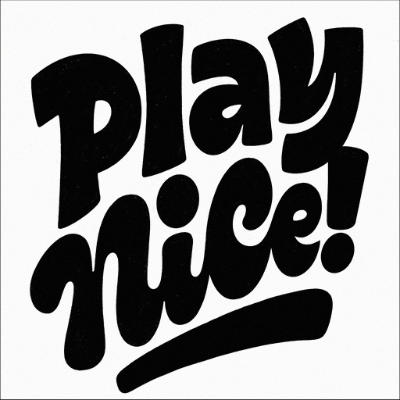

In [8]:
def img_from_local():
  uploaded = files.upload()
  filename = list(uploaded)[0]
  return BytesIO(uploaded[filename])

img = Image.open(img_from_local())
img.save('/content/uploaded.png','PNG')
img

In [9]:
imgOrigin = cv2.imread('/content/uploaded.png')

In [10]:
width = int(512)
height = int(512)
dim = (width, height)
  
# resize image
img1 = cv2.resize(imgOrigin, dim)

In [11]:
print(img1.shape)

(512, 512, 3)


In [12]:
def encode_img_latents(imgs):
  if not isinstance(imgs, list):
    imgs = [imgs]

  img_arr = np.stack([np.array(img) for img in imgs], axis=0)
  img_arr = img_arr / 255.0
  img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
  img_arr = 2 * (img_arr - 0.5)

  latent_dists = vae.encode(img_arr.to(device))
  latent_samples = latent_dists.sample()
  latent_samples *= 0.18215

  return latent_samples

In [13]:
img_latents = encode_img_latents([img1])

In [14]:
img_latents

tensor([[[[ 9.0775e-01,  2.6021e+00,  1.5930e+00,  ...,  2.6537e+00,
            1.4631e+00,  2.5548e+00],
          [ 8.5601e-01,  1.5720e+00,  1.3193e+00,  ...,  1.1953e+00,
            1.2697e+00,  2.1158e+00],
          [ 1.3891e+00,  1.9392e+00,  1.8392e+00,  ...,  1.9147e+00,
            1.3268e+00,  2.1741e+00],
          ...,
          [ 1.0571e+00,  1.6904e+00,  1.1926e+00,  ...,  1.2745e+00,
            1.5353e+00,  1.8868e+00],
          [ 8.9153e-01,  1.5910e+00,  1.6099e+00,  ...,  1.2531e+00,
            1.2687e+00,  1.8173e+00],
          [ 4.4495e-01, -2.1233e-02, -2.2114e-01,  ...,  5.4217e-01,
           -4.5982e-01,  3.0923e-01]],

         [[ 4.7321e-01,  5.0417e-01, -6.1152e-02,  ...,  6.9663e-01,
            4.6943e-01,  1.9025e-01],
          [ 1.6178e+00,  1.7900e+00,  1.2211e+00,  ...,  1.7697e+00,
            2.3596e+00,  3.0730e-01],
          [ 1.7349e+00,  1.2799e+00,  1.2018e+00,  ...,  1.2654e+00,
            1.8252e+00,  3.5314e-01],
          ...,
     

In [15]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents)

  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images

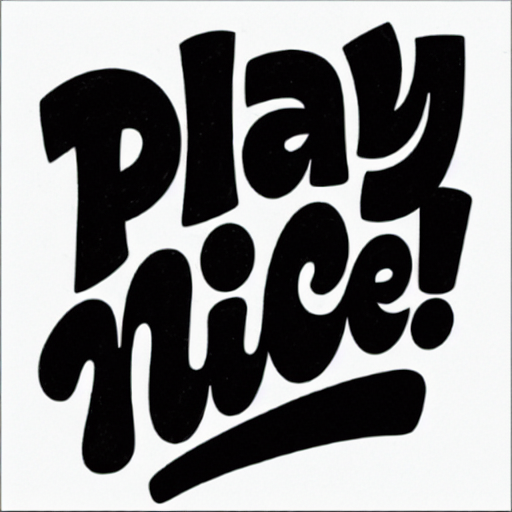

In [16]:
dec_img = decode_img_latents(img_latents)[0]
dec_img

In [17]:
scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

In [30]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False, start_step=10):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  if start_step > 0:
    start_timestep = scheduler.timesteps[start_step]
    start_timesteps = start_timestep.repeat(latents.shape[0]).long()

    noise = torch.randn_like(latents)
    latents = scheduler.add_noise(latents, noise, start_timesteps)

  latent_hist = [latents]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps[start_step:])):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents)['prev_sample']
      latent_hist.append(latents)
  
  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents
  
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=1, start_step=0):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents, start_step=start_step)
  
  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

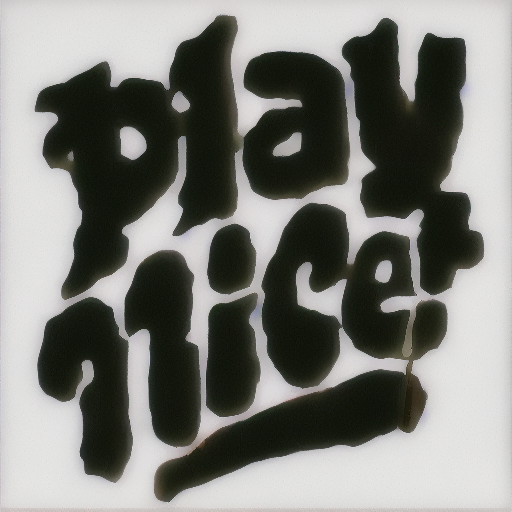

In [36]:
prompt = 'painting of summer fields in holland'
imgGen = prompt_to_img(prompt, num_inference_steps=70, latents=img_latents,
                    start_step=23)[0]
imgGen